In [6]:
import sys
sys.path.insert(0, '../')

# train_model pipeline

This notebook explains how to train a model after extracting features. The models employed here are simple neural networks taking features as inputs and outputting the four KPIs as targets.

#### ***Quick Start***

If you are only interested in training the model using default parameters (i.e. only features from Hydra) you can do so by calling

```shell
python src/train_hydra_mr.py
```

This will train a model on 5 fold cross validation, saving the best model underway in ```models/```. Along with this, loss curves will be plotted underway, along with a final plot showing the average loss across all folds. These plots are saved in ```reports/figures/model_results```.

## Step 1 - Creating the datasets and dataloaders

**File:** ```src/data/feature_dataloader.py```

In the feature_dataloader.py the Features dataset is defined. This dataset can be used to easily load the extracted features from the features.hdf5 file. It is implemented as a standard torch dataset, meaning it works by iterating over the data via ```_getitem__```. It is structured similarly to the Platoon dataset, i.e. with indices pointing to the features in the training, validation and test sets, and then retrieving these when iterated over.

To create a train and validation dataset over a specific fold, you can set the fold parameter. Below we create a train and val dataset over fold 1 using features from Hydra only.


In [10]:
from src.data.feature_dataloader import Features

# Create the dataset
trainset = Features(data_path = '../data/processed/features.hdf5', 
                    data_type = 'train',
                    feature_extractors = ['HydraMV_8_64'], 
                    name_identifier = '',
                    kpi_window = 1,
                    fold = 1,
                    verbose = True)

valset = Features(data_path = '../data/processed/features.hdf5', 
                    data_type = 'val',
                    feature_extractors = ['HydraMV_8_64'], 
                    name_identifier = '',
                    kpi_window = 1,
                    fold = 1,
                    verbose = True)

Arguments: 
                     Data Path:             ../data/processed/features.hdf5 
                     Data Type:             train 
                     Data length:           6550 
                     Features selected:                      
                         - Names:           ['HydraMV_8_64'] 
                         - KPI Window Size: 1 
                     
Arguments: 
                     Data Path:             ../data/processed/features.hdf5 
                     Data Type:             val 
                     Data length:           1638 
                     Features selected:                      
                         - Names:           ['HydraMV_8_64'] 
                         - KPI Window Size: 1 
                     


## Step 2 - Training the model

**File:** ```src/train_hydra_mr.py```

The ```train_hydra_mr.py``` script trains the model across the defined folds. First we will demonstrate how to train the model over a single fold, and then extrapolate to all folds in the extracted features.

#### ***Training over a single fold***

We define a train function that takes a model as input, train and validation dataloaders, fold, number of epochs and learning rate.

> **NOTE:** The function is setup to work with wandb for logging in ```train_hydra_mr.py```, but this can be disabled by simply calling ```wandb disabled``` in your console.

***Imports***

In [23]:
import os
import torch
import numpy as np
import torch.nn as nn
import time

from tqdm import tqdm
from argparse import ArgumentParser
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader 

from src.util.utils import set_all_seeds
from src.models.hydramr import HydraMRRegressor
from src.data.feature_dataloader import Features

# Set all seeds for reproducibility
set_all_seeds(42)

***Parameters that can be set via arguments***

In [24]:
epochs = 50                                 # Number of epochs to train the model
batch_size = 32                             # Batch size of the data
lr = 1e-6                                   # Learning rate
feature_extractors = ['HydraMV_8_64']       # Which features to use
name_identifier = ''                        # Name identifier (for loading features)
folds = 5                                   # Number of folds to train on for cross-validation
model_name = 'HydraMRRegressor'             # Model name to use (currently only HydraMRRegressor is supported)
weight_decay = 0.0                          # Weight decay of the optimizer (Adam)
hidden_dim = 64                             # Hidden dimension size of the model
project_name = 'wandb_test'                 # Project name for wandb (call wandb disabled to not use wandb, and wandb init to initialize)
dropout = 0.5                               # Dropout between hidden dimensions
model_depth = 0                             # Model depth (how many hidden layers)
batch_norm = True                           # Whether to use batch normalization

***Train function***

In [33]:
def train(model: HydraMRRegressor, 
          train_loader: DataLoader, 
          val_loader: DataLoader,
          fold: int,
          epochs: int = 10, 
          lr: float = 0.001,
          ):
    """Training loop for the Hydra-MR model.
    
    This function trains the Hydra-MR model using the provided training data and validation data loaders.
    The model is trained for a specified number of epochs with a given learning rate.

    The model is saved in the models directory with the name of the model along with the best model during training.
    Training curves are saved in the reports/figures/model_results directory.
    
    Parameters:
    ----------
        model (HydraMRRegressor): The model to train.
        train_loader (DataLoader): The training data loader.
        val_loader (DataLoader): The validation data loader.
        epochs (int, optional): Number of epochs to train. Defaults to 10.
        fold (int): Which fold to train on (used for saving the model and plots)
        lr (float, optional): Learning rate of the optimizer. Defaults to 0.001.
    """
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Set optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Set loss function
    loss_fn = nn.MSELoss()

    epoch_train_losses = []
    epoch_val_losses = []
    best_val_loss = np.inf
    
    # Iterate over segments of data (each segment is a time series where the minimum speed is above XX km/h)
    for i, epoch in enumerate(range(epochs)):
        start = time.time()
        train_iterator = tqdm(train_loader, unit="batch", position=0, leave=False)
        model.train()
        train_losses = []
        for data, target in train_iterator:
            data, target = data.to(device), target.to(device)
            output = model(data)

            loss = loss_fn(output, target)
            train_losses.append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if len(epoch_val_losses) > 0:
                train_iterator.set_description(f"Training Epoch {epoch+1}/{epochs}, Train loss: {loss.item():.3f}, Last epoch train loss: {epoch_train_losses[i-1]:.3f}, Last epoch val loss: {epoch_val_losses[i-1]:.3f}")
            else:
                train_iterator.set_description(f"Training Epoch {epoch+1}/{epochs}, Train loss: {loss.item():.3f}")

        mean_train_loss = np.mean(train_losses)
        epoch_train_losses.append(mean_train_loss)
        
        val_iterator = tqdm(val_loader, unit="batch", position=0, leave=False)
        model.eval()
        val_losses = []
        for val_data, target in val_iterator:
            val_data, target = val_data.to(device), target.to(device)
            output = model(val_data)
            val_loss = loss_fn(output, target)

            val_losses.append(val_loss.item())
            val_iterator.set_description(f"Validating Epoch {epoch+1}/{epochs}, Train loss: {loss.item():.3f}, Last epoch train loss: {epoch_train_losses[i-1]:.3f}, Val loss: {val_loss:.3f}, Mean Val Loss: {np.mean(val_losses):.3f}")
        
        # save best model
        if np.mean(val_losses) < best_val_loss:
            end = time.time()
            best_val_loss = np.mean(val_losses)
            torch.save(model.state_dict(), f'../models/best_{model.name}_{fold}.pt')
            print(f"Saving best model with mean val loss: {np.mean(val_losses):.3f} at epoch {epoch+1} ({end-start:.2f}s)")
            
        mean_val_loss = np.mean(val_losses)
        epoch_val_losses.append(mean_val_loss)

        x = np.arange(1, epoch+2, step=1)
        plt.plot(x, epoch_train_losses, label="Train loss")
        plt.plot(x, epoch_val_losses, label="Val loss")
        # plt.xticks(x)
        plt.title('Loss per epoch')
        plt.ylim(0, min(5, max(max(epoch_train_losses), max(epoch_val_losses))+1))
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        os.makedirs(f'../reports/figures/model_results/{model.name}', exist_ok=True)
        plt.savefig(f'../reports/figures/model_results/{model.name}/loss_{fold}.pdf')
        plt.close()
    
    torch.save(model.state_dict(), f'../models/{model.name}.pt')

    return epoch_train_losses, epoch_val_losses, best_val_loss

***Training a model for one fold***

Let us use the train and validation datasets we created earlier for fold 1 and train a model for 10 epochs.

Saving best model with mean val loss: 1.069 at epoch 1 (6.61s)


Saving best model with mean val loss: 1.032 at epoch 2 (6.46s)


Saving best model with mean val loss: 1.015 at epoch 3 (6.52s)


Saving best model with mean val loss: 1.004 at epoch 4 (6.42s)


Saving best model with mean val loss: 0.991 at epoch 5 (6.33s)


Saving best model with mean val loss: 0.976 at epoch 6 (6.38s)


Saving best model with mean val loss: 0.973 at epoch 7 (6.39s)


Saving best model with mean val loss: 0.958 at epoch 8 (6.38s)


Saving best model with mean val loss: 0.952 at epoch 9 (6.38s)


Saving best model with mean val loss: 0.947 at epoch 10 (6.34s)
Best validation loss: 0.947


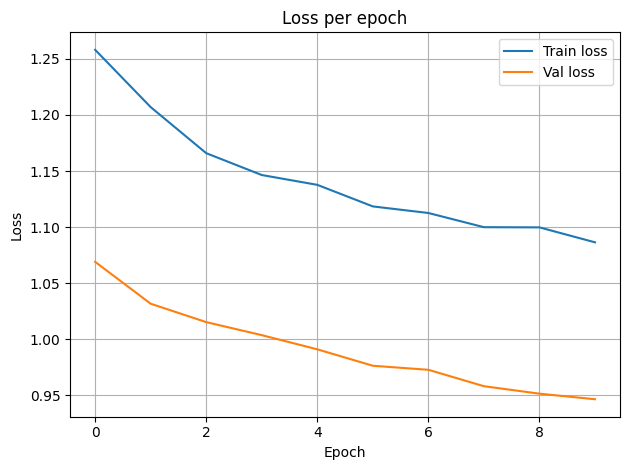

In [34]:
# Set device for gpu training if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup the dataloaders to iterate over the features
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False)

# Get the input shape
input_shape, target_shape = trainset.get_data_shape()

# Initialize the model
model = HydraMRRegressor(in_features=input_shape[0], 
                         out_features=target_shape[0], 
                         hidden_dim=hidden_dim, 
                         model_depth=model_depth, 
                         dropout=dropout, 
                         batch_norm=batch_norm).to(device)

# Train the model for 10 epochs
train_losses, val_losses, best_val_loss = train(model=model, train_loader=train_loader, val_loader=val_loader, fold=1, epochs=10, lr=lr)

# Print the best validation loss
print(f"Best validation loss: {best_val_loss:.3f}")

# Plot the training and validation losses
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### ***Training over all 5 folds***

We now expand the training functionality to train on 5 fold cross validation (which we acquired during feature extraction).

In [ ]:
# Set epochs to allow for faster training
epochs = 5

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Variables to hold the losses
train_losses = []
val_losses = []
best_val_losses = []

for fold in range(folds):
   print(f"Training fold {fold+1}/{folds}")
   
   # Create dataset over the given fold
   trainset = Features(data_path='../data/processed/features.hdf5', data_type='train', feature_extractors=feature_extractors, name_identifier=name_identifier, fold=fold, verbose=False)
   valset = Features(data_path='../data/processed/features.hdf5', data_type='val', feature_extractors=feature_extractors, name_identifier=name_identifier, fold=fold, verbose=False)
   
   train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
   val_loader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=0)
   
   input_shape, target_shape = trainset.get_data_shape()
   
   # Create model
   # As a baseline, MultiRocket_50000 will output 49728 features, Hydra_8_64 will output 5120 features, and there are 4 KPIs (targets)
   model = HydraMRRegressor(in_features=input_shape[0], 
                           out_features=target_shape[0], 
                           hidden_dim=hidden_dim, 
                           dropout=dropout,
                           name=model_name,
                           model_depth=model_depth,
                           batch_norm=batch_norm
                           ).to(device)
   
   # Train
   k_fold_train_losses, k_fold_val_losses, best_val_loss = train(model=model, train_loader=train_loader, val_loader=val_loader, fold=fold, epochs=epochs, lr=lr)

   train_losses.append(k_fold_train_losses)
   val_losses.append(k_fold_val_losses)
   best_val_losses.append(best_val_loss)
   
mean_best_val_loss = np.mean(best_val_losses)
std_best_val_loss = np.std(best_val_losses)
print(f"Mean best validation loss: {mean_best_val_loss:.3f}")
print(f"Standard deviation of best validation loss: {std_best_val_loss:.3f}")

# plot training curves
for i in range(folds):
   x = np.arange(1, epochs+1, step=1)
   plt.plot(x, train_losses[i], c="b", alpha=0.2)
   plt.plot(x, val_losses[i], linestyle='--', c="r", alpha=0.2)

plt.plot(x, np.mean(train_losses, axis=0), label="Train loss", c="b")
plt.plot(x, np.mean(val_losses, axis=0), label="Val loss", c="r", linestyle='--')
plt.ylim(0, min(7, max(np.max(train_losses), np.max(val_losses))+0.2))
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.tight_layout()
os.makedirs(f'../reports/figures/model_results/{model.name}', exist_ok=True)
plt.savefig(f'../reports/figures/model_results/{model.name}/loss_combined.pdf')
plt.plot()